In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from scipy.stats import norm, rankdata
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=1)

['santander-customer-transaction-prediction', 'bestfe']


In [2]:
random_state = 42
np.random.seed(random_state)
train_raw = pd.read_csv('../input/santander-customer-transaction-prediction/train.csv')
test_raw = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')

In [3]:
train = train_raw
test = test_raw

target = train.pop('target')
train_ids = train.pop('ID_code')
test_ids = test.pop('ID_code')
len_train = len(train)
#Merging test and train.
merged = pd.concat([train, test])
#Saving the list of original features in a new list `original_features`.
original_features = merged.columns

In [4]:
for col in merged.columns:

    # Square
    merged[col+'^2'] = merged[col] * merged[col]
  
    # Cube
    merged[col+'^3'] = merged[col] * merged[col] * merged[col]

    # 4th power
    merged[col+'^4'] = merged[col] * merged[col] * merged[col] * merged[col]

    # Cumulative percentile (not normalized)
    merged[col+'_cp'] = rankdata(merged[col]).astype('float32')

    # exp
    merged[col+'_exp'] = np.exp(merged[col])
    
    # Cumulative normal percentile
    merged[col+'_cnp'] = norm.cdf(merged[col]).astype('float32')
#Getting the list of names of the added features.
new_features = set(merged.columns) - set(original_features)


In [5]:
bestFeature=pd.read_csv('../input/bestfe/bestFe.csv')
bf=bestFeature["feature"].unique()
#pd.DataFrame(bf,columns=["var"])

#merged=merged[pd.DataFrame(bf,columns=["var"])["var"]]

In [6]:
newFe=[]
for i in range(len(bf)):
    if bf[i] not in original_features:
        newFe.append(bf[i])
l1=list(original_features)
for i in range(len(newFe)):
    l1.append(newFe[i])

In [7]:
l1=l1[:204]
pd.DataFrame(l1,columns=["var"])
merged=merged[pd.DataFrame(l1,columns=["var"])["var"]]

In [8]:
train=merged.iloc[:len_train]
test=merged.iloc[len_train:]

feature_list = train.columns

test = test[feature_list]

In [9]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [10]:
lgb_params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 230,
    "min_sum_heassian_in_leaf": 40,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : random_state,
    "verbosity" : 1,
    "seed": random_state
}

In [11]:
df_train = train
df_train["target"] = target
df_train["ID_code"] = train_ids
df_test = test
df_test['ID_code'] = test_ids

In [12]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
oof = df_train[['ID_code', 'target']]
oof['predict'] = 0
predictions = df_test[['ID_code']]
val_aucs = []
feature_importance_df = pd.DataFrame()

In [13]:
features = [col for col in df_train.columns if col not in ['target', 'ID_code']]
X_test = df_test[features].values

In [14]:
for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train, df_train['target'])):
    X_train, y_train = df_train.iloc[trn_idx][features], df_train.iloc[trn_idx]['target']
    X_valid, y_valid = df_train.iloc[val_idx][features], df_train.iloc[val_idx]['target']
    
    N = 5
    p_valid,yp = 0,0
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds=3000,
                        verbose_eval = 1000,
                        evals_result=evals_result
                       )
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
    predictions['fold{}'.format(fold+1)] = yp/N

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.89448	valid_1's auc: 0.872497
[2000]	training's auc: 0.904497	valid_1's auc: 0.882802
[3000]	training's auc: 0.911582	valid_1's auc: 0.889486
[4000]	training's auc: 0.91657	valid_1's auc: 0.893321
[5000]	training's auc: 0.920265	valid_1's auc: 0.895685
[6000]	training's auc: 0.923211	valid_1's auc: 0.897052
[7000]	training's auc: 0.925675	valid_1's auc: 0.897898
[8000]	training's auc: 0.927942	valid_1's auc: 0.898368
[9000]	training's auc: 0.930045	valid_1's auc: 0.898669
[10000]	training's auc: 0.932078	valid_1's auc: 0.898848
[11000]	training's auc: 0.934002	valid_1's auc: 0.898915
[12000]	training's auc: 0.935873	valid_1's auc: 0.898888
[13000]	training's auc: 0.937715	valid_1's auc: 0.898847
[14000]	training's auc: 0.939528	valid_1's auc: 0.898839
Early stopping, best iteration is:
[11091]	training's auc: 0.934172	valid_1's auc: 0.898961
Training until validation scores don't improve for 3000 r

In [15]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.900481704, std: 0.002900504. All auc: 0.900475490.


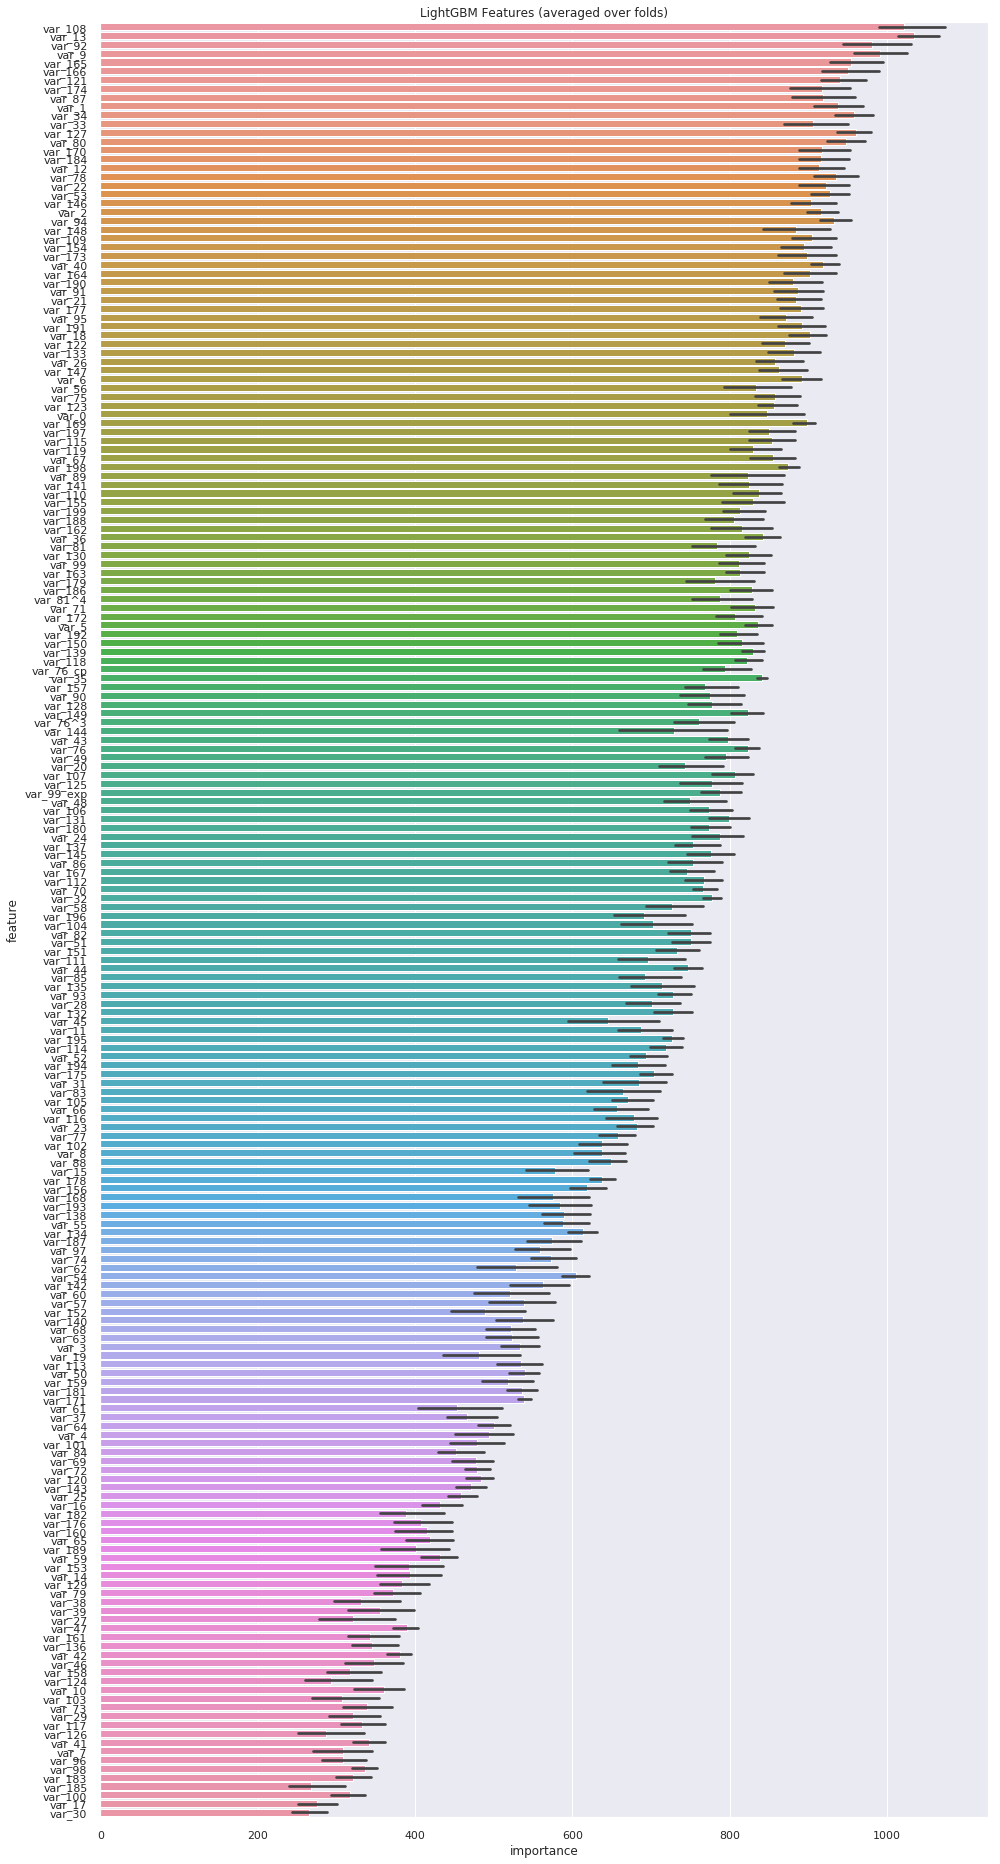

In [16]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')


In [17]:
# submission
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
predictions.to_csv('lgb_all_predictions.csv', index=None)
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions['target']
sub_df.to_csv("lgb_submission.csv", index=False)
oof.to_csv('lgb_oof.csv', index=False)